In [1]:
import numpy as np

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

В одном из выпусков программы "Разрушители легенд" проверялось, действительно ли заразительна зевота. В эксперименте участвовало 50 испытуемых, проходивших собеседование на программу. Каждый из них разговаривал с рекрутером; в конце 34 из 50 бесед рекрутер зевал. Затем испытуемых просили подождать решения рекрутера в соседней пустой комнате. Во время ожидания 10 из 34 испытуемых экспериментальной группы и 4 из 16 испытуемых контрольной начали зевать. Таким образом, разница в доле зевающих людей в этих двух группах составила примерно 4.4%. Ведущие заключили, что миф о заразительности зевоты подтверждён. Можно ли утверждать, что доли зевающих в контрольной и экспериментальной группах отличаются статистически значимо? Посчитайте достигаемый уровень значимости при альтернативе заразительности зевоты, округлите до четырёх знаков после десятичной точки. 

In [2]:
Test = [1] * 10 + [0] * 24
Control = [1] * 4 + [0] * 12

In [3]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [4]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [60]:
print('p value: ', proportions_diff_z_test(proportions_diff_z_stat_ind(Test, Control), 'greater'))

p value:  0.37293045872523534


Имеются данные измерений двухсот швейцарских тысячефранковых банкнот, бывших в обращении в первой половине XX века. Сто из банкнот были настоящими, и сто — поддельными. На рисунке ниже показаны измеренные признаки:
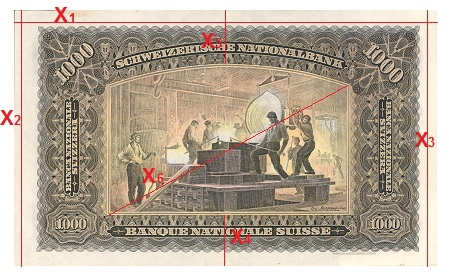

Отделите 50 случайных наблюдений в тестовую выборку с помощью функции sklearn.cross_validation.train_test_split (зафиксируйте random state = 1). На оставшихся 150 настройте два классификатора поддельности банкнот:

    -логистическая регрессия по признакам X_1,X_2,X_3
    -логистическая регрессия по признакам X_4,X_5,X_6

In [6]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [7]:
data = pd.read_csv('banknotes.txt', header = 0, sep = '\t')
data.head()

,X1,X2,X3,X4,X5,X6,real
0,214.8,131.0,131.1,9.0,9.7,141.0,1
1,214.6,129.7,129.7,8.1,9.5,141.7,1
2,214.8,129.7,129.7,8.7,9.6,142.2,1
3,214.8,129.7,129.6,7.5,10.4,142.0,1
4,215.0,129.6,129.7,10.4,7.7,141.8,1


In [12]:
X = data.iloc[:, :-1]
y = data.real

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [28]:
X_train1 = X_train[['X1', 'X2', 'X3']]
X_test1 = X_test[['X1', 'X2', 'X3']]

X_train2 = X_train[['X4', 'X5', 'X6']]
X_test2 = X_test[['X4', 'X5', 'X6']]

In [29]:
regr1 = LogisticRegression()
regr1.fit(X_train1, y_train)

regr2 = LogisticRegression()
regr2.fit(X_train2, y_train)

LogisticRegression()

In [30]:
regrPredict1 = regr1.predict(X_test1)
regrPredict2 = regr2.predict(X_test2)

In [33]:
y_test = y_test.values

In [73]:
#Составим список ошибок (1, если есть ошибка и 0, если нет)
Error1 = (regrPredict1 != y_test)
Error2 = (regrPredict2 != y_test)

In [70]:
def proportions_diff_confint_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    sample = list(zip(sample1, sample2))
    n = len(sample)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

In [71]:
def proportions_diff_z_stat_rel(sample1, sample2):
    sample = list(zip(sample1, sample2))
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

In [74]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" \
      % proportions_diff_confint_rel(Error1, Error2))

95% confidence interval for a difference between proportions: [0.073511, 0.286489]


In [49]:
round(proportions_diff_confint_rel(Error1, Error2)[0], 4)

0.0735

In [50]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_rel(Error1, Error2)))

p-value: 0.000923


Ежегодно более 200000 людей по всему миру сдают стандартизированный экзамен GMAT при поступлении на программы MBA. Средний результат составляет 525 баллов, стандартное отклонение — 100 баллов. Сто студентов закончили специальные подготовительные курсы и сдали экзамен. Средний полученный ими балл — 541.4. Проверьте гипотезу о неэффективности программы против односторонней альтернативы о том, что программа работает. Отвергается ли на уровне значимости 0.05 нулевая гипотеза? Введите достигаемый уровень значимости, округлённый до 4 знаков после десятичной точки. 


In [52]:
z = (541.4 - 525) / (100 / np.sqrt(100))
z

1.6399999999999977

In [53]:
pValue = 1 - scipy.stats.norm.cdf(z)
round(pValue, 4)

0.0505


Оцените теперь эффективность подготовительных курсов, средний балл 100 выпускников которых равен 541.5. Отвергается ли на уровне значимости 0.05 та же самая нулевая гипотеза против той же самой альтернативы? Введите достигаемый уровень значимости, округлённый до 4 знаков после десятичной точки. 

In [55]:
z = (541.5 - 525) / (100 / np.sqrt(100))
z

1.65

In [56]:
pValue = 1 - scipy.stats.norm.cdf(z)
round(pValue, 4)

0.0495